In [51]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clip
import os

In [52]:
dark_directory = "C:/kiavash/codes/Astro_Lab/hw8/dark"

flat_directory = "C:/kiavash/codes/Astro_Lab/hw8/flat"

flat_dark_directory = "C:/kiavash/codes/Astro_Lab/hw8/flat_dark"

jabbar_directory = "C:/kiavash/codes/Astro_Lab/hw8/jabbar"


In [ ]:
def sigma_clipped_mean(stack, sigma=4.5, maxiters=2):
    clipped = sigma_clip(stack, sigma=sigma, maxiters=maxiters, axis=0)
    print("Clipped fraction:", np.mean(clipped.mask))
    return np.mean(clipped, axis=0)

def make_master_dark(dark_files):
    return sigma_clipped_mean(dark_files)

def make_master_flat(flat_dark, flat_files):
    corrected_flats = flat_files - flat_dark
    corrected_flats[corrected_flats < 1] = np.median(corrected_flats)
    master = sigma_clipped_mean(corrected_flats)
    return master / np.median(master)

def preprocess(master_dark, master_flat, images):
    results = []
    for image in images:
        result = (image - master_dark) / master_flat
        results.append(result)
    return(results)
    
def load_images(directory):
    images = []
    for file in os.listdir(directory):
        if file.endswith('.fit') or file.endswith('.fits'):
            data = fits.getdata(os.path.join(directory, file))
            images.append(data)
    return np.array(images)

Clipped fraction: 0.0
min : 0.057
max : 254.9745
avg : 51.347039564995946


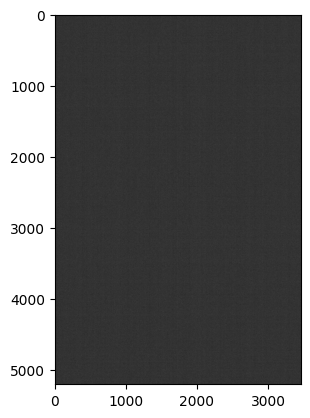

In [54]:
dark_files = load_images(dark_directory)
master_dark = make_master_dark(dark_files)

print("min :", master_dark.min())
print("max :", master_dark.max())
print("avg :", master_dark.mean())

plt.imshow(master_dark, cmap="gray")

Clipped fraction: 1.6648419998348477e-08
min : 12.835965000000002
max : 254.97449999999998
avg : 51.459047386389805


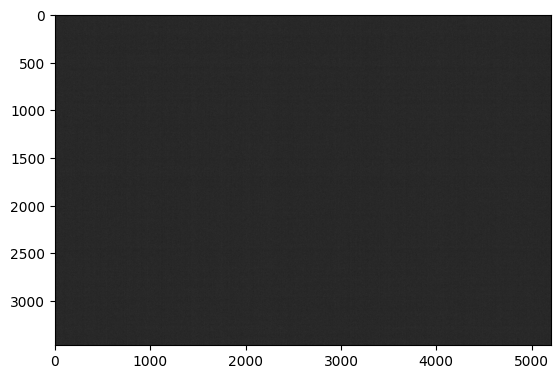

In [55]:
flat_dark_files = load_images(flat_dark_directory)
master_flat_dark = make_master_dark(flat_dark_files)

print("min :", master_flat_dark.min())
print("max :", master_flat_dark.max())
print("avg :", master_flat_dark.mean())

plt.imshow(master_flat_dark, cmap="gray")

C:\Users\ExoGame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Clipped fraction: 1.057042539577681e-08
min : 0.04307950482321821
max : 1.4139103543194171
avg : 0.9991800209560402


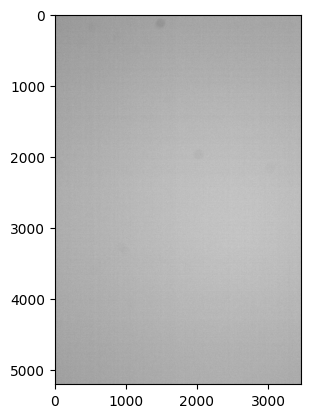

In [56]:
flat_files = load_images(flat_directory)
master_flat = make_master_flat(master_flat_dark, flat_files).T

print("min :", master_flat.min())
print("max :", master_flat.max())
print("avg :", master_flat.mean())

plt.imshow(master_flat, cmap="gray")

min : -114.99812373106802
max : 1690.452346164172
avg : 83.21967872305926


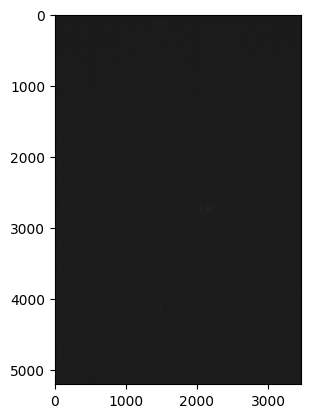

In [57]:
jabbar_files = load_images(jabbar_directory)
jabbar_results = preprocess(master_dark, master_flat, jabbar_files)

print("min :", jabbar_results[0].min())
print("max :", jabbar_results[0].max())
print("avg :", jabbar_results[0].mean())

plt.imshow(jabbar_results[0], cmap="gray")

In [ ]:
# Coordinates of the same star in each image (x, y)
# i did not consider the fact that siril's y-axis is inverted so the coordinates are not correct
# but it doesn't matter since i'm using this for aligning pictures and later on i inverted "dy".
# we only care about relative shift of the images here.
star_coords = [
    (2049, 2443),
    (2102, 2408),  
    (2148, 2381),  
    (2214, 2342),
    (2267, 2309),
    (2330, 2271),
    (2402, 2226),
    (2458, 2192),
    (2517, 2156),
    (2572, 2121),
    (2619, 2093),
    (2667, 2064),
]

In [ ]:
from scipy.ndimage import shift

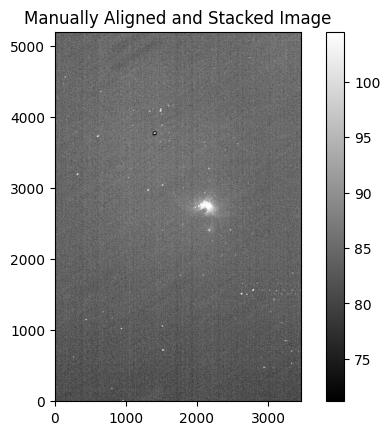

In [ ]:
def align_images_by_star(calibrated_images, star_coords):
    reference_x, reference_y = star_coords[0]
    aligned_images = []

    for image, (x, y) in zip(calibrated_images, star_coords):
        dx = reference_x - x
        dy = -(reference_y - y)
        shifted = shift(image, shift=(dy, dx), mode='reflect')
        aligned_images.append(shifted)

    return np.array(aligned_images)

def stack_aligned_images(aligned_images, method="mean"):
    if method == "mean":
        return np.mean(aligned_images, axis=0)
    elif method == "median":
        return np.median(aligned_images, axis=0)
    else:
        raise ValueError("Invalid stacking method. Use 'mean' or 'median'.")

aligned_images = align_images_by_star(jabbar_results, star_coords)
final_image = stack_aligned_images(aligned_images, method="mean")

# Display final result
vmin, vmax = np.percentile(final_image, [5, 99.5])
plt.imshow(final_image, cmap="gray", origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("Manually Aligned and Stacked Image")
plt.show()

In [65]:
print("min :", final_image.min())
print("max :", final_image.max())
print("avg :", final_image.mean())

min : 23.234579690283425
max : 300.4584544397082
avg : 84.34796371985415


In [66]:
hdu = fits.PrimaryHDU(final_image)
hdu.writeto("final_stacked_image.fits", overwrite=True)

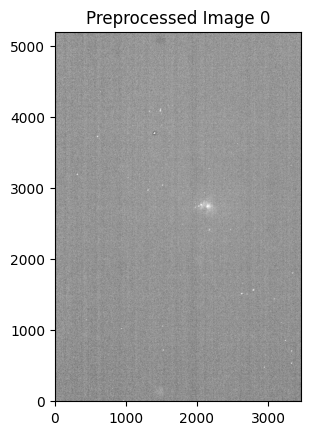

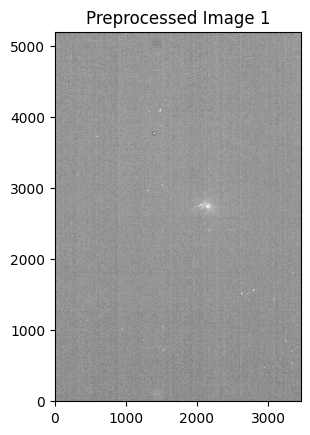

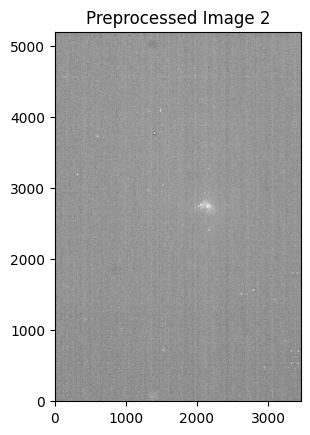

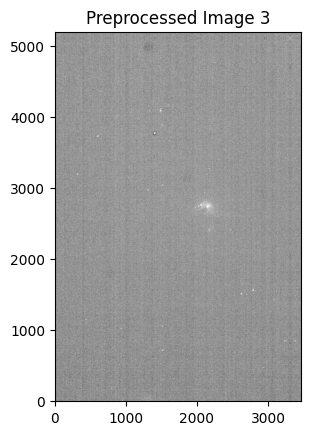

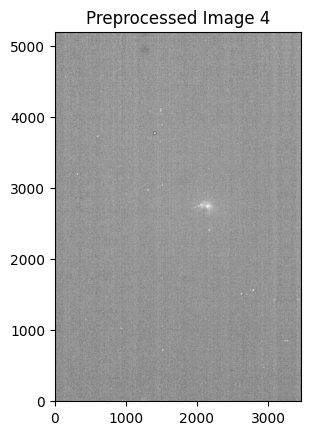

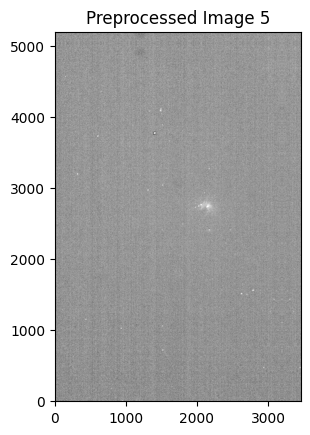

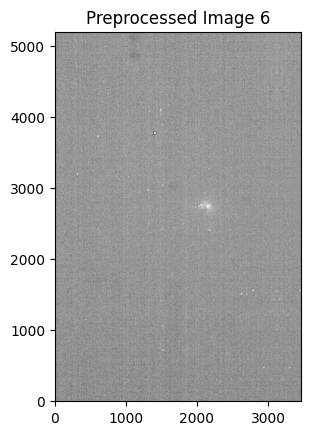

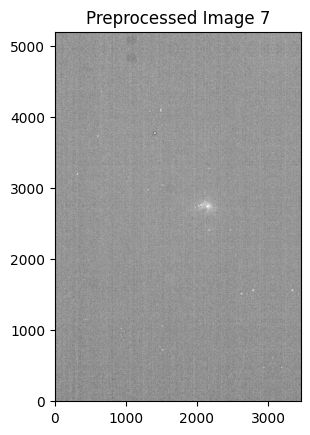

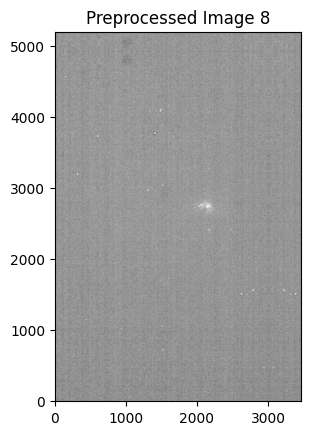

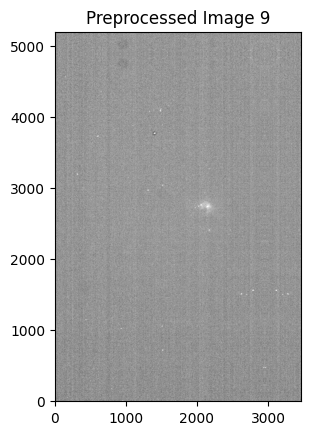

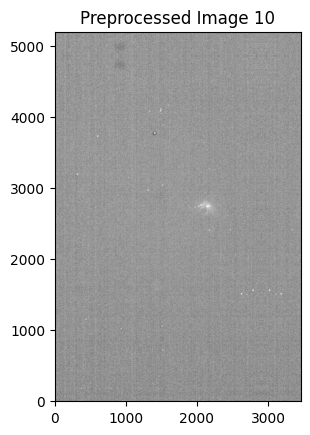

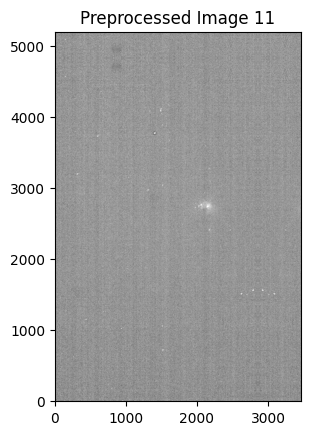

In [67]:
# Just to visualize some calibrated images
for i, img in enumerate(aligned_images[:12]):
    plt.imshow(img, cmap="gray", origin="lower", vmin=0, vmax=np.percentile(img, 99))
    plt.title(f"Preprocessed Image {i}")
    plt.show()
